# Detecção de Emoções com Base em Keypoints Faciais

Neste notebook, eu desenvolvi uma abordagem para detectar expressões faciais (Alegre, Neutro e Raiva) utilizando a extração dos keypoints do rosto com o MediaPipe Face Mesh.

Eu segui os seguintes passos:

- **Extração dos Keypoints:**  
  Eu utilizei o MediaPipe para identificar os pontos de referência do meu rosto a partir de imagens salvas no meu Google Drive.  
  Utilizei os pontos-chave 33 e 263 (representando os cantos externos dos olhos) para calcular a distância interocular, que servirá como referencial para normalizar as medições.

- **Cálculo das Métricas:**  
  - **Boca:** Eu calculei a abertura da boca com a diferença vertical entre os keypoints 13 (lábio superior) e 14 (lábio inferior) e, em seguida, dividi esse valor pela distância interocular para obter a razão da boca.  
  - **Bochecha:** Eu comparei pontos da bochecha (por exemplo, 159 e 205 para o lado esquerdo, e 386 e 425 para o lado direito) e calculei a média das diferenças verticais, normalizando pelo mesmo referencial, para obter a razão da bochecha.  
  - **Sobrancelhas:** Eu me concentrei na distância entre as sobrancelhas internas (utilizando os keypoints 55 e 285) e a normalizei pela distância interocular, de forma que expressões de raiva – em que as sobrancelhas tendem a ficar mais próximas – fiquem evidentes.

- **Visualização e Classificação:**  
  Para facilitar a comparação entre as métricas, eu optei por usar um gráfico de radar (spider chart), no qual as razões são multiplicadas por 100 para realçar as diferenças.  
  Com base em limiares empíricos definidos por mim, eu classifiquei a expressão em ALEGRE, RAIVA ou NEUTRO.

Esta abordagem demonstra que é possível implementar uma detecção de expressões faciais com baixo custo computacional, sem a necessidade de modelos complexos de deep learning.


In [32]:
# instala a versão 0.10.5 do mediapipe (que evita problemas com o módulo de áudio) e o opencv-python
!pip install mediapipe==0.10.5 opencv-python


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

PROCESSANDO IMAGEM: /content/drive/MyDrive/meu_rosto.jpg



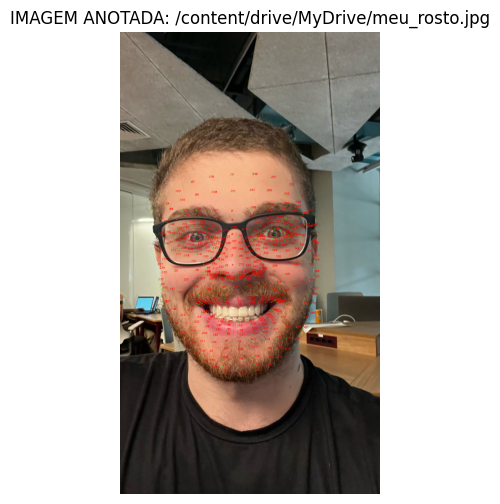

Distância Interocular   : 366.31
Abertura da Boca (px)   : 59.00
Razão da Boca           : 0.161
Razão da Bochecha       : 0.433
Dist. Sobrancelhas (px) : 112.36
Razão Sobrancelhas      : 0.307



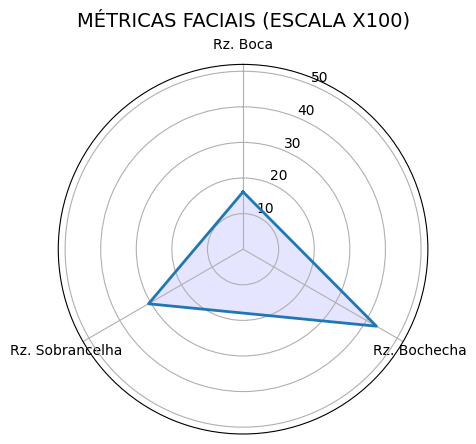

****************************************
            RESULTADO FINAL             
****************************************

        >>> ALEGRE <<<

****************************************

--------------------------------------------------


PROCESSANDO IMAGEM: /content/drive/MyDrive/meu_rosto2.jpg



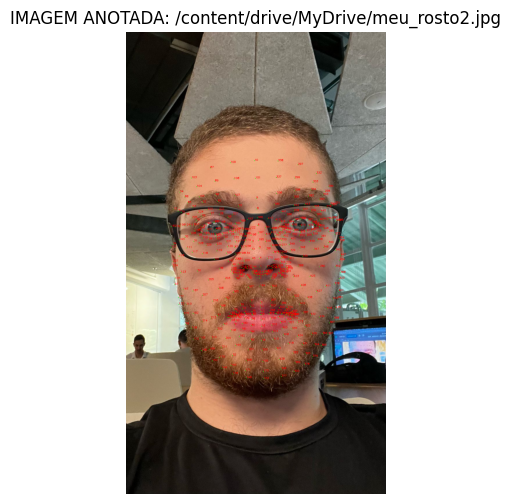

Distância Interocular   : 408.24
Abertura da Boca (px)   : 1.00
Razão da Boca           : 0.002
Razão da Bochecha       : 0.489
Dist. Sobrancelhas (px) : 124.10
Razão Sobrancelhas      : 0.304



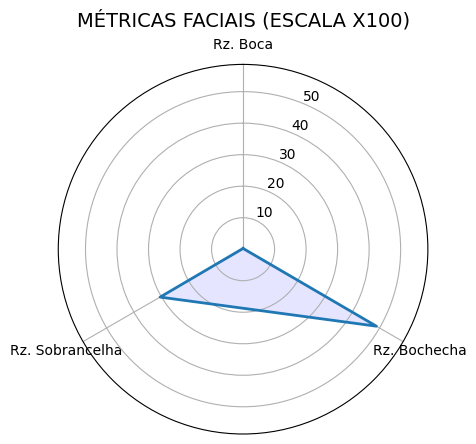

****************************************
            RESULTADO FINAL             
****************************************

        >>> NEUTRO <<<

****************************************

--------------------------------------------------


PROCESSANDO IMAGEM: /content/drive/MyDrive/meu_rosto3.jpg



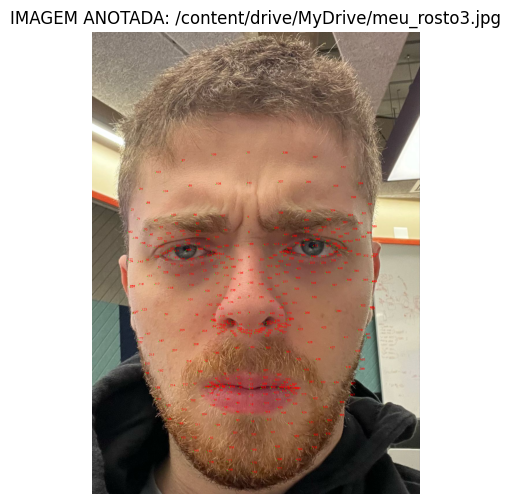

Distância Interocular   : 599.24
Abertura da Boca (px)   : 0.00
Razão da Boca           : 0.000
Razão da Bochecha       : 0.506
Dist. Sobrancelhas (px) : 172.19
Razão Sobrancelhas      : 0.287



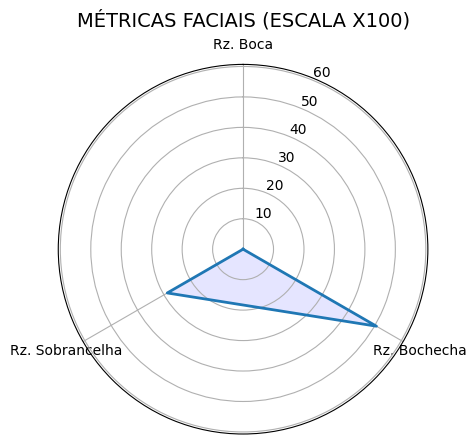

****************************************
            RESULTADO FINAL             
****************************************

        >>> RAIVA <<<

****************************************

--------------------------------------------------



In [33]:
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt

# monta o drive do google (lembre de autorizar o acesso)
from google.colab import drive
drive.mount('/content/drive')

# lista com apenas 3 imagens (ajuste conforme seus arquivos)
lista_imagens = [
    '/content/drive/MyDrive/meu_rosto.jpg',
    '/content/drive/MyDrive/meu_rosto2.jpg',
    '/content/drive/MyDrive/meu_rosto3.jpg'
]

def plot_radar_chart(labels, values, title="Radar Chart"):
    """
    plota um gráfico de radar (spider chart) para as métricas fornecidas.
    - labels: lista de rótulos (ex.: ["Razão Boca", "Razão Bochecha", ...])
    - values: lista de valores correspondentes
    - title: título do gráfico
    """
    # número de variáveis
    n = len(labels)

    # ângulos para cada eixo
    angles = [i / float(n) * 2 * np.pi for i in range(n)]
    angles += angles[:1]  # repete o primeiro valor para fechar o círculo

    # cria o subplot em coordenadas polares
    ax = plt.subplot(111, polar=True)

    # ajusta o offset e a direção do eixo
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # define os rótulos do eixo radial
    plt.xticks(angles[:-1], labels)

    # define limite máximo do eixo radial
    max_val = max(values) * 1.2
    if max_val == 0:
        max_val = 1
    plt.ylim(0, max_val)

    # repete o primeiro valor para fechar o polígono
    vals = list(values)
    vals += vals[:1]

    # plota a linha e preenche o interior
    ax.plot(angles, vals, linewidth=2, linestyle='solid')
    ax.fill(angles, vals, 'b', alpha=0.1)

    # título do gráfico
    plt.title(title, size=14, y=1.08)
    plt.show()

def processar_imagem(image_path):
    """
    1) carrega a imagem
    2) extrai os keypoints faciais com mediapipe face mesh
    3) calcula métricas (distância interocular, razão da boca, razão da bochecha e distância entre sobrancelhas)
    4) plota um radar chart SOMENTE com as razões (boca, bochecha, sobrancelha), escalonadas (x100), para realçar diferenças
    5) classifica a expressão e exibe o resultado.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"\nERRO AO CARREGAR: {image_path}\n")
        return

    print("\n===========================================================")
    print(f"PROCESSANDO IMAGEM: {image_path}")
    print("===========================================================\n")

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5
    ) as face_mesh:

        annotated_image = image.copy()
        h, w, _ = image.shape

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)

        keypoints = []
        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            for idx, landmark in enumerate(face_landmarks.landmark):
                x = int(landmark.x * w)
                y = int(landmark.y * h)
                keypoints.append((idx, x, y))
                cv2.circle(annotated_image, (x, y), 1, (0, 255, 0), -1)
                cv2.putText(annotated_image, str(idx), (x, y),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        else:
            print("NENHUM ROSTO DETECTADO!\n")
            return

        # exibe a imagem com keypoints
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title(f"IMAGEM ANOTADA: {image_path}")
        plt.axis('off')
        plt.show()

        # converte keypoints para dicionário
        kp_dict = {idx: (x, y) for idx, x, y in keypoints}

        # keypoints necessários
        # - interocular: 33 (olho esquerdo externo) e 263 (olho direito externo)
        # - boca: 13 (lábio superior central) e 14 (lábio inferior central)
        # - bochecha: 159 e 205 (lado esquerdo), 386 e 425 (lado direito)
        # - sobrancelhas internas: 55 e 285
        required_keys = [33, 263, 13, 14, 159, 205, 386, 425, 55, 285]
        if not all(k in kp_dict for k in required_keys):
            print("ALGUNS KEYPOINTS NECESSÁRIOS NÃO FORAM DETECTADOS.\n")
            return

        def euclidean_distance(p1, p2):
            return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

        # distancia interocular
        d_olhos = euclidean_distance(kp_dict[33], kp_dict[263])

        # abertura da boca
        abertura_boca = abs(kp_dict[13][1] - kp_dict[14][1])
        razao_boca = abertura_boca / d_olhos

        # bochecha
        dist_esq_bochecha = abs(kp_dict[205][1] - kp_dict[159][1])
        dist_dir_bochecha = abs(kp_dict[425][1] - kp_dict[386][1])
        razao_bochecha = (dist_esq_bochecha + dist_dir_bochecha) / (2 * d_olhos)

        # sobrancelhas
        dist_sobrancelhas = euclidean_distance(kp_dict[55], kp_dict[285])
        eyebrow_ratio = dist_sobrancelhas / d_olhos

        # exibe métricas no console
        print(f"Distância Interocular   : {d_olhos:.2f}")
        print(f"Abertura da Boca (px)   : {abertura_boca:.2f}")
        print(f"Razão da Boca           : {razao_boca:.3f}")
        print(f"Razão da Bochecha       : {razao_bochecha:.3f}")
        print(f"Dist. Sobrancelhas (px) : {dist_sobrancelhas:.2f}")
        print(f"Razão Sobrancelhas      : {eyebrow_ratio:.3f}\n")

        # plota um radar chart APENAS com as razões, multiplicadas por 100 para realçar diferenças
        labels = ["Rz. Boca", "Rz. Bochecha", "Rz. Sobrancelha"]
        valores = [razao_boca * 100, razao_bochecha * 100, eyebrow_ratio * 100]
        plot_radar_chart(labels, valores, title="MÉTRICAS FACIAIS (ESCALA X100)")

        # limiares empíricos
        limiar_boca_alegre = 0.15
        limiar_sobrancelha_raiva = 0.30  # se < 0.30 => RAIVA

        if eyebrow_ratio < limiar_sobrancelha_raiva:
            expressao = "RAIVA"
        elif razao_boca > limiar_boca_alegre:
            expressao = "ALEGRE"
        else:
            expressao = "NEUTRO"

        # saída final formatada
        print("****************************************")
        print("            RESULTADO FINAL             ")
        print("****************************************\n")
        print(f"        >>> {expressao.upper()} <<<\n")
        print("****************************************\n")
        print("--------------------------------------------------\n")

# itera sobre as 3 imagens e processa cada uma
for caminho in lista_imagens:
    processar_imagem(caminho)

# ------------------------------ FIM DO CÓDIGO ------------------------------


# Conclusão

Neste projeto, eu demonstrei que é viável inferir expressões faciais a partir dos keypoints extraídos com o MediaPipe Face Mesh. Em resumo:

- **Extraí os keypoints** do meu rosto a partir de imagens salvas no Google Drive, utilizando o MediaPipe Face Mesh.
- **Calculei métricas importantes** como a distância interocular, a razão da boca, a razão da bochecha e a razão entre as sobrancelhas.
- **Utilizei um gráfico de radar** para visualizar as métricas de forma comparativa, o que me permitiu identificar diferenças sutis entre expressões.
- **Defini limiares empíricos** que me ajudaram a classificar as expressões como ALEGRE, RAIVA ou NEUTRO.

Com esse método, eu consegui criar um sistema simples, mas eficaz, para detecção de emoções, demonstrando que a inferência baseada em regras matemáticas pode ser uma alternativa interessante e de baixo custo computacional para análise facial.
